# Continuing a region stochastic BOLD simulation

In many cases, it is useful to perform an initial simulation to allow the transient dynamics to dissipate, and then continue the simulation using the steady state obtained from the initial simulation as the initial conditions. The TVB web interface allows for this by 'branching' a loaded simulation. From a Python script, we need to handle the details ourselves. This demo shows how to do that for a region-level, stochastic simulation with the BOLD monitor.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import pickle as cPickle
from tvb.simulator.lab import *

LOG = get_logger('demo')

## Initial transient

First, we build and configure the initial simulator,

In [2]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(), 
    connectivity=connectivity.Connectivity.from_file(),                      
    coupling=coupling.Linear(a=numpy.array([0.0126])),
    simulation_length=1e4,
    integrator=integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=numpy.array([0.001]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500.0),
        monitors.ProgressLogger(period=1e3)
    )
).configure()

WARNING  File 'hemispheres' not found in ZIP.


let it run,

In [3]:
(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

   INFO  step 1 time 0.0001 s
   INFO  step 16001 time 1.0001 s
   INFO  step 32001 time 2.0001 s
   INFO  step 48001 time 3.0001 s
   INFO  step 64001 time 4.0001 s
   INFO  step 80001 time 5.0001 s
   INFO  step 96001 time 6.0001 s
   INFO  step 112001 time 7.0001 s
   INFO  step 128001 time 8.0001 s
   INFO  step 144001 time 9.0001 s


and plot the transient:

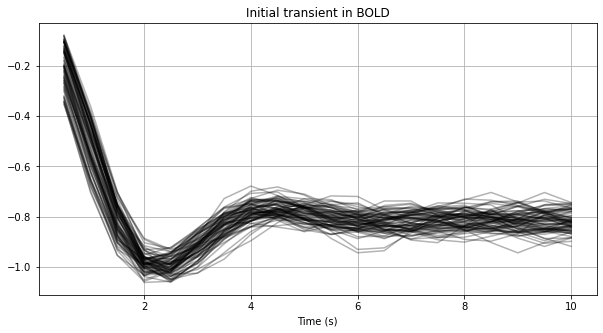

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(bold_time * 1e-3, bold_data[:, 0, :, 0], 'k', alpha=0.3)
plt.title('Initial transient in BOLD')
plt.xlabel('Time (s)')
plt.grid(True);

To save the state of the simulator, we need to put a few arrays into files:

In [5]:
sim_state_fname = 'sim_state.pickle'

with open(sim_state_fname, 'wb') as file_descr:
    cPickle.dump({
        'history': sim.history.buffer,
        'current_step': sim.current_step,
        'current_state': sim.current_state,
        'bold_inner': sim.monitors[1]._interim_stock,
        'bold': sim.monitors[1]._stock,
        'rng': sim.integrator.noise.random_stream.get_state()
    }, file_descr)

The simulation state is now saved in the current folder:

In [ ]:
!ls -lh sim_state.pickle

We are free to dispose of the simulator:

In [6]:
del sim

## Continuing the simulation

Now we want to continue the simulator above with the saved state. In different scenarios, this might be in a different script, on a different day, so we need to build the simulator object again:

In [7]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(), 
    connectivity=connectivity.Connectivity.from_file(),                      
    coupling=coupling.Linear(a=numpy.array([0.0126])),
    simulation_length=1e4,
    integrator=integrators.HeunStochastic(
        dt=2 ** -4,
        noise=noise.Additive(nsig=numpy.array([0.001]))),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        monitors.Bold(period=500.0),
        monitors.ProgressLogger(period=1e3)
    )
).configure()

WARNING  File 'hemispheres' not found in ZIP.


load its state,

In [8]:
with open(sim_state_fname, 'rb') as file_descr:
    state = cPickle.load(file_descr)

sim.history.buffer = state['history']
sim.current_step = state['current_step']
sim.current_state = state['current_state']
sim.monitors[1]._interim_stock = state['bold_inner']
sim.monitors[1]._stock = state['bold']
sim.integrator.noise.random_stream.set_state(state['rng'])

and run it again; note that the step and time start off where the old simulator stopped:

In [9]:
(tavg_time, tavg_data), (bold_time, bold_data), _ = sim.run()

   INFO  step 160001 time 10.0001 s
   INFO  step 176001 time 11.0001 s
   INFO  step 192001 time 12.0001 s
   INFO  step 208001 time 13.0001 s
   INFO  step 224001 time 14.0001 s
   INFO  step 240001 time 15.0001 s
   INFO  step 256001 time 16.0001 s
   INFO  step 272001 time 17.0001 s
   INFO  step 288001 time 18.0001 s
   INFO  step 304001 time 19.0001 s


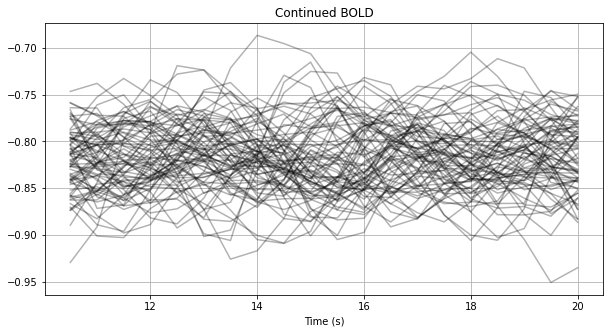

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(bold_time * 1e-3, bold_data[:, 0, :, 0], 'k', alpha=0.3)
plt.title('Continued BOLD')
plt.xlabel('Time (s)')
plt.grid(True);

The continued BOLD does not show the transient present in the initial simulation.